# 0 - Prerequisitos

In [ ]:
# install python packages
!pip install pandas numpy scipy scikit-learn matplotlib seaborn

In [1]:
from urllib.request import urlopen
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# function for parsing API data to dataframe
def read_data_api(url, data_path='results', read_level = 4):
  """Parse JSON data from MercadoLibre URL API.

    Keyword arguments:
    url -- API url to extract data
    data_path -- path to extract records from JSON data
  """
  json_url = urlopen(url)
  data = json.loads(json_url.read())

  return pd.json_normalize(data, record_path = data_path, max_level = read_level)

In [3]:
def get_subcat(cat):
    """Get a list of subcategories or children categories from a category id.

      Keyword arguments:
      cat -- category id to read
    """
    return read_data_api('https://api.mercadolibre.com/categories/'+str(cat), data_path='children_categories')

In [4]:
def get_data(URL = 'https://api.mercadolibre.com/sites/MLA/search?q=tv%204k&offset=', offset=0):
  """Get data from a MercadoLibre url API by increasing offset.

    Keyword arguments:
    url -- API url to extract data
    offset -- start offset
  """
  data = read_data_api(URL+str(offset))

  for i in range((offset + 50), 1000, 50):
    temp = read_data_api(URL+str(i+1))
    data = pd.concat([data, temp])

  return data.reset_index()

In [5]:
def get_data_by_cat(cat):
    """Get data from a category id using subcategories or children categories, using MercadoLibre API to read JSON data.

      Keyword arguments:
      cat -- category id to read
    """
    test = get_subcat(cat)
    data = pd.DataFrame()

    for i in test.id:
        url = 'https://api.mercadolibre.com/sites/MLA/search?category='+str(i)+'&offset='
        temp = get_data(URL = url)
        data = pd.concat([data, temp])
    
    return data.reset_index()

In [6]:
pd.options.display.float_format = '{:.2f}'.format

# 2 - Modelado

**Objetivo**

Estimar un modelo que permita realizar pronosticos sobre el campo *sold_quantity*, a partir de la informacion de la publicacion

## 2.1 - Obtención de datos

Usando las funciones de la primera prueba, se obtienen los datos a utilizar, que corresponden a la categoria MLA1144

In [7]:
# obtain data
CAT = 'MLA1144'

subcats = get_subcat(CAT)
data = get_data_by_cat(CAT)
data.head(5)

,level_0,index,id,site_id,title,price,sale_price,currency_id,available_quantity,sold_quantity,...,seller_address.city.id,seller_address.city.name,seller_address.latitude,seller_address.longitude,differential_pricing.id,seller.eshop.eshop_rubro.id,seller.eshop.eshop_rubro.name,seller.eshop.eshop_rubro.category_id,installments,prices
0,0,0,MLA906332763,MLA,Auriculares Gamer Kotion Each G9000 Black Y Blue,2160.00,None,ARS,484,17,...,TUxBQ0NBUGNiZGQx,Córdoba,,,nan,NaN,NaN,NaN,nan,nan
1,1,1,MLA885869798,MLA,Joystick Inalámbrico Sony Dualshock 4 Jet Black,9299.00,None,ARS,2,217,...,TUxBQkJBTDMxMDZa,Balvanera,,,33678187.00,NaN,NaN,NaN,nan,nan
2,2,2,MLA880563648,MLA,Joystick Inalámbrico Sony Dualshock 3 Black,1990.00,None,ARS,162,264,...,None,San Andres,,,nan,NaN,NaN,NaN,nan,nan
3,3,3,MLA833372951,MLA,Joystick Inalámbrico Sony Dualshock 4 Magma Red,9010.00,None,ARS,43,216,...,TUxBQk1PTjUxOTJa,Monserrat,,,nan,NaN,NaN,NaN,nan,nan
4,4,4,MLA906120473,MLA,Joystick Inalámbrico Sony Dualshock 4 Midnight...,9030.00,None,ARS,1,4,...,TUxBQkJFTDcyNTJa,Belgrano,,,nan,NaN,NaN,NaN,nan,nan


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Columns: 102 entries, level_0 to prices
dtypes: bool(5), float64(24), int64(6), object(67)
memory usage: 5.2+ MB


In [9]:
# descriptive stats
data.describe()

,level_0,index,price,available_quantity,sold_quantity,order_backend,seller.id,seller.eshop.eshop_id,seller.eshop.eshop_status_id,seller.eshop.seller,...,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,installments.quantity,installments.amount,installments.rate,differential_pricing.id,installments,prices
count,6946.00,6946.00,6946.00,6946.00,6946.00,6946.00,6946.00,2772.00,2772.00,2772.00,...,6895.00,6896.00,6896.00,6895.00,6903.00,6903.00,6903.00,952.00,0.00,0.00
mean,495.80,24.42,38215.62,136.07,55.87,25.50,205832051.08,246342.56,1.23,140207701.38,...,40.18,2844.52,0.00,16.38,11.19,1631.81,59.69,33678187.00,nan,nan
std,286.74,14.43,1345123.12,1830.92,153.34,14.44,179567811.49,131506.30,0.42,111914993.06,...,172.94,7601.54,0.02,45.62,2.05,6059.91,25.01,0.00,nan,nan
min,0.00,0.00,22.00,1.00,0.00,1.00,1276.00,901.00,1.00,102496.00,...,0.00,0.00,0.00,0.00,6.00,2.08,0.00,33678187.00,nan,nan
25%,248.00,12.00,750.00,1.00,0.00,13.00,68978583.00,153084.00,1.00,62603122.00,...,0.00,54.00,0.00,0.00,12.00,106.28,70.17,33678187.00,nan,nan
50%,496.00,24.00,2500.00,1.00,5.00,25.00,159996087.00,262020.00,1.00,113193386.00,...,1.00,494.00,0.00,1.00,12.00,354.52,70.17,33678187.00,nan,nan
75%,744.00,37.00,6099.00,1.00,50.00,38.00,301298026.00,336872.00,1.00,204003036.00,...,10.00,2863.00,0.01,9.00,12.00,850.85,70.17,33678187.00,nan,nan
max,999.00,49.00,111111111.00,50000.00,5000.00,50.00,706437437.00,461334.00,2.00,670260128.00,...,3810.00,95204.00,0.89,752.00,12.00,98556.79,70.17,33678187.00,nan,nan


## 2.2 - Transformación y creación de carácteristicas

Se tienen cerca de 100 carácteristicas (features) disponibles. De estas, se realiza una seleccián arbitraria y se clasifican en caracteristicas cuantitativas (numericas) y cualitativas (categoricas)

In [10]:
var_num = ['sold_quantity',
'price',
'listing_type_id',
'condition',
'seller.seller_reputation.transactions.canceled',
'seller.seller_reputation.transactions.ratings.negative',
'seller.seller_reputation.transactions.ratings.positive',
'seller.seller_reputation.metrics.claims.rate',
'seller.seller_reputation.metrics.delayed_handling_time.rate',
'seller.seller_reputation.metrics.cancellations.rate',
]

In [11]:
var_cat = ['accepts_mercadopago',
'category_id',
'seller.seller_reputation.power_seller_status',
'address.state_name',
'shipping.free_shipping',
'shipping.mode',
'shipping.logistic_type',
]

Ademas, se calculan dos carácteristicas que pueden dar informacion adicional

In [12]:
# create Pct difference between price and original price feature
data['pct'] = (1 - data['price']/data['original_price'])*100

# create proportion between total and completed transactions feature
data['transact_pct'] = (1 - data['seller.seller_reputation.transactions.total']/data['seller.seller_reputation.transactions.completed'])*100

Se crea un nuevo dataframe, inicialmente con las variables numericas

In [13]:
df = data[var_num]
df['pct'] = data['pct']
df['transact_pct'] = data['transact_pct']

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 12 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   sold_quantity                                                6946 non-null   int64  
 1   price                                                        6946 non-null   float64
 2   listing_type_id                                              6946 non-null   object 
 3   condition                                                    6946 non-null   object 
 4   seller.seller_reputation.transactions.canceled               6897 non-null   float64
 5   seller.seller_reputation.transactions.ratings.negative       6897 non-null   float64
 6   seller.seller_reputation.transactions.ratings.positive       6897 non-null   float64
 7   seller.seller_reputation.metrics.claims.rate                 6896 non-null   f

Se tranforman las variables categorias a una codificacion numerica.

Primero se revisan valores nulos.

In [15]:
data[var_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 7 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   accepts_mercadopago                           6946 non-null   bool  
 1   category_id                                   6946 non-null   object
 2   seller.seller_reputation.power_seller_status  4201 non-null   object
 3   address.state_name                            6946 non-null   object
 4   shipping.free_shipping                        6946 non-null   bool  
 5   shipping.mode                                 6946 non-null   object
 6   shipping.logistic_type                        6946 non-null   object
dtypes: bool(2), object(5)
memory usage: 285.0+ KB


Se reemplazan los valoes nulos en la caracteristica *seller.seller_reputation.power_seller_status* por un valor indicativo

In [16]:
data['seller.seller_reputation.power_seller_status'].value_counts(dropna=False)


platinum    3164
NaN         2745
gold         570
silver       467
Name: seller.seller_reputation.power_seller_status, dtype: int64

In [17]:
data['seller.seller_reputation.power_seller_status'].replace(to_replace=[np.NaN], value='NA', inplace=True)
data['seller.seller_reputation.power_seller_status'].value_counts(dropna=False)

platinum    3164
NA          2745
gold         570
silver       467
Name: seller.seller_reputation.power_seller_status, dtype: int64

In [18]:
# Use OneHot Encoding for categorical features
enc = preprocessing.OneHotEncoder(drop='first')
var_cat_enc = enc.fit_transform(data[var_cat])

pd.DataFrame(var_cat_enc.toarray(), columns=enc.get_feature_names())

,x1_MLA10855,x1_MLA10858,x1_MLA10861,x1_MLA10864,x1_MLA10866,x1_MLA11179,x1_MLA11199,x1_MLA113259,x1_MLA113261,x1_MLA1152,...,x3_Tierra del Fuego,x3_Tucumán,x4_True,x5_me2,x5_not_specified,x6_custom,x6_drop_off,x6_fulfillment,x6_not_specified,x6_xd_drop_off
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6941,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
6942,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
6943,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
6944,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00


In [19]:
# Add categorical features to dataframe
df = pd.concat([df, 
    pd.DataFrame(var_cat_enc.toarray(), columns=enc.get_feature_names())], 
    axis=1)

Se revisan nuevamente valores nulos, existen filas que no tienen datos en las caracteristicas de calificacion, posiblemente sean de vendedores nuevos. Igualmente para la caracteristica calculada *transact_pct*.

In [20]:
df[var_num].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 10 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   sold_quantity                                                6946 non-null   int64  
 1   price                                                        6946 non-null   float64
 2   listing_type_id                                              6946 non-null   object 
 3   condition                                                    6946 non-null   object 
 4   seller.seller_reputation.transactions.canceled               6897 non-null   float64
 5   seller.seller_reputation.transactions.ratings.negative       6897 non-null   float64
 6   seller.seller_reputation.transactions.ratings.positive       6897 non-null   float64
 7   seller.seller_reputation.metrics.claims.rate                 6896 non-null   f

In [21]:
df[['pct', 'transact_pct']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6946 entries, 0 to 6945
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pct           350 non-null    object 
 1   transact_pct  6667 non-null   float64
dtypes: float64(1), object(1)
memory usage: 108.7+ KB


La estrategia para abordar los valores nulos es la siguiente:

* Eliminar las filas que tengan valores nulos en las caracteristicas de *seller.seller_reputation.transactions*
* hacer imputación de la caracteristica *pct* y *transact_pct*, reemplazandolos por valor 0

In [22]:
df.dropna(subset=var_num, inplace=True)
df.dropna(subset=['transact_pct'], inplace=True)

In [23]:
df['pct'].replace(to_replace=[np.nan, np.infty], value=0, inplace=True)
df['transact_pct'].replace(to_replace=[np.nan, np.inf, (-np.inf)], value=0, inplace=True)
df[['pct', 'transact_pct']].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6667 entries, 0 to 6911
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pct           6667 non-null   float64
 1   transact_pct  6667 non-null   float64
dtypes: float64(2)
memory usage: 156.3 KB


## 2.3 - Selección de carácteristicas

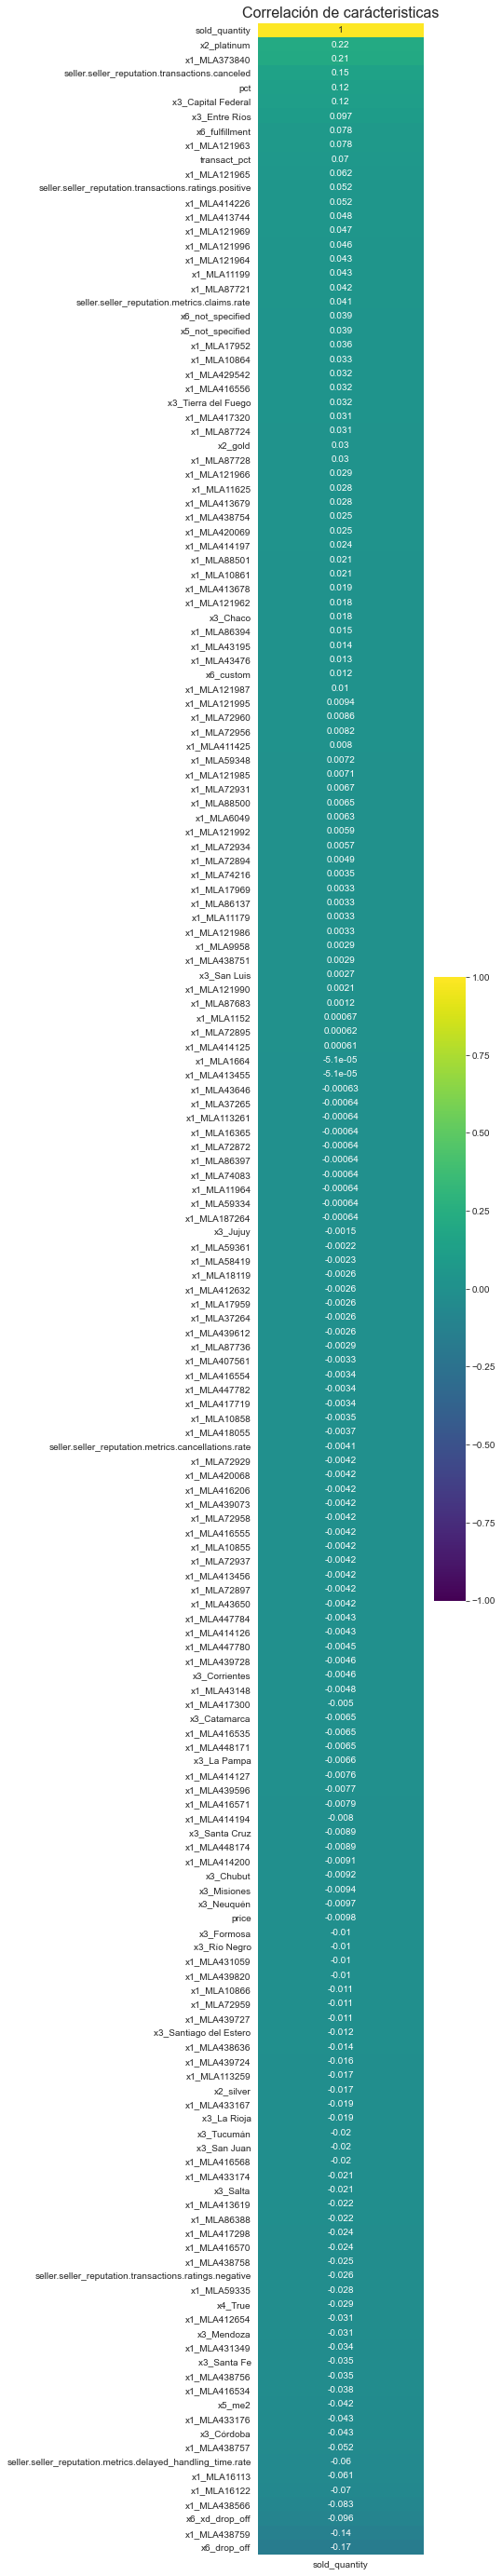

In [24]:
corr = df.corr()

sold_corr = pd.DataFrame(corr['sold_quantity'])
sold_corr.sort_values(by='sold_quantity', inplace=True, ascending=False)

sns.set_style("whitegrid")
plt.figure(figsize=(4,50))
sns.heatmap(sold_corr, vmin=-1, vmax=1, annot=True, cmap='viridis', center=0)
plt.title('Correlación de carácteristicas', size=16)
plt.show()

In [25]:
# select features with correlation greater than 0.03 or less than -0.01 
selected_feat = sold_corr[(sold_corr > 0.03) | (sold_corr < -0.01)].dropna().index
df_model = df[selected_feat]
df_model

,sold_quantity,x2_platinum,x1_MLA373840,seller.seller_reputation.transactions.canceled,pct,x3_Capital Federal,x3_Entre Ríos,x6_fulfillment,x1_MLA121963,transact_pct,...,x1_MLA433176,x3_Córdoba,x1_MLA438757,seller.seller_reputation.metrics.delayed_handling_time.rate,x1_MLA16113,x1_MLA16122,x1_MLA438566,x6_xd_drop_off,x1_MLA438759,x6_drop_off
0,17,0.00,0.00,22.00,0.00,0.00,0.00,0.00,1.00,-7.41,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,217,1.00,0.00,1838.00,0.00,1.00,0.00,0.00,0.00,-7.17,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,264,1.00,0.00,308.00,0.00,0.00,0.00,0.00,0.00,-5.66,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,216,1.00,0.00,908.00,0.00,1.00,0.00,0.00,0.00,-4.45,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,4,0.00,0.00,241.00,0.00,1.00,0.00,0.00,0.00,-7.43,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
6886,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
6890,0,0.00,0.00,56.00,0.00,0.00,0.00,0.00,0.00,-10.53,...,0.00,0.00,0.00,0.01,0.00,0.00,0.00,1.00,1.00,0.00
6910,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00


In [26]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6667 entries, 0 to 6911
Data columns (total 74 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   sold_quantity                                                6667 non-null   int64  
 1   x2_platinum                                                  6667 non-null   float64
 2   x1_MLA373840                                                 6667 non-null   float64
 3   seller.seller_reputation.transactions.canceled               6667 non-null   float64
 4   pct                                                          6667 non-null   float64
 5   x3_Capital Federal                                           6667 non-null   float64
 6   x3_Entre Ríos                                                6667 non-null   float64
 7   x6_fulfillment                                               6667 non-null   f

## 2.4 - Modelado

Particionado de datos en entrenamiento y pruebas

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_model[df_model.columns.difference(['sold_quantity'])], df_model['sold_quantity'], 
                                    random_state=66, test_size=0.3)

In [28]:
print('Dimensiones datos entrenamiento')
print(y_train.shape)
print(X_train.shape)

Dimensiones datos entrenamiento
(4666,)
(4666, 73)


Selección de modelos

Se escogen basicamente regresores

In [29]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNetCV, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR

In [30]:
# hyperparameters dicc to use with grid search CV
dtr_parameters = {
    'max_features': ('auto', 'log2'),
}

linreg_parameters = {
    'fit_intercept': (True, False),
    'normalize': (True, False),
}

sgdreg_parameters = {
    'penalty': ('l2', 'l1'),
    'learning_rate': ('optimal', 'invscaling'),
    'fit_intercept': (True, False),
    'alpha': (0.0001, 0.001, 0.001, 0.01),
}

mlpreg_parameters = {
    'activation': ('identity', 'tanh', 'relu'),
    'learning_rate': ('constant', 'optimal', 'invscaling', 'adaptive'),
}

enreg_parameters = {
    'fit_intercept': (True, False),
    'normalize': (True, False),
}

lasso_parameters = {
    'fit_intercept': (True, False),
    'normalize': (True, False),
    'alpha': (1, 2, 3, 5, 10)
}


grid = list(range(-5, 7, 1))
svr_parameters = {
    'C': [2**i for i in grid], 
    'epsilon': [2**i for i in grid],
    'loss': ('epsilon_insensitive', 'squared_epsilon_insensitive'),
    'fit_intercept': ('True', 'False'),
}

In [31]:
# Create a list of model with their hyperparameter dicc
models = []
models.append(('dtr', DecisionTreeRegressor(random_state=66), dtr_parameters))
models.append(('linreg', LinearRegression(), linreg_parameters))
models.append(('sgdreg', SGDRegressor(), sgdreg_parameters))
models.append(('mlpreg', MLPRegressor(random_state=66, early_stopping=True, max_iter=1000), mlpreg_parameters))
models.append(('enreg', ElasticNetCV(random_state=66, cv=10), enreg_parameters))
models.append(('lasso', Lasso(random_state=66), lasso_parameters))
models.append(('SVR', LinearSVR(random_state=66), svr_parameters))

### 2.4.1 - Entrenamiento de modelos

In [32]:
results = []
names = []

print('## Model Training start ##')

# cada modelo es entrenado utilizando validacion cruzada, seleccionando como metrica el r^2
for name, model, params in models:
    print(f'### Next model:  {name} ###')
    g_search = GridSearchCV(model, params, cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=4, return_train_score=True)
    g_search.fit(X_train, y_train)

    names.append(name)
    results.append(g_search)

print('## Model Training finished ##')

## Model Training start ##
### Next model:  dtr ###
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
### Next model:  linreg ###
Fitting 10 folds for each of 4 candidates, totalling 40 fits
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
### Next model:  sgdreg ###
Fitting 10 folds for each of 32 candidates, totalling 320 fits
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 320 out of 320 | elapsed:    8.4s finished
### Next model:  mlpreg ###
Fitting 10 folds for each of 12 candidates, totalling 120 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | e

Se muestra la configuración de los modelos optimizados por validación cruzada

In [33]:
for i in results:
    print(i.best_estimator_)

DecisionTreeRegressor(max_features='log2', random_state=66)
LinearRegression(normalize=True)
SGDRegressor(alpha=0.01, fit_intercept=False, learning_rate='optimal')
MLPRegressor(activation='tanh', early_stopping=True, max_iter=1000,
             random_state=66)
ElasticNetCV(cv=10, normalize=True, random_state=66)
Lasso(alpha=1, fit_intercept=False, normalize=True, random_state=66)
LinearSVR(C=32, epsilon=64, fit_intercept='True', random_state=66)


## 2.5 - Evaluación de modelos

Se muestran los resultados de entrenamiento con los datos de entrenamiento

In [34]:
for i in range(len(names)):
    y_pred = results[i].predict(X_test)
    print(names[i] + ' mean training score: ' + str(results[i].best_score_))
    print(names[i] + ' rmse: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    print(names[i] + ' mae: ' + str(mean_absolute_error(y_test, y_pred)))
    print(names[i] + ' r2: ' + str(r2_score(y_test, y_pred)))
    print('\n')

dtr mean training score: -22356.28602071216
dtr rmse: 148.7001594801629
dtr mae: 53.76172608111647
dtr r2: 0.12164353081023282


linreg mean training score: -20419.725855786903
linreg rmse: 148.60989425578882
linreg mae: 64.34770351132374
linreg r2: 0.1227095818475833


sgdreg mean training score: -2.0973423342680624e+30
sgdreg rmse: 4040036673287275.5
sgdreg mae: 1506113064844467.0
sgdreg r2: -6.483634888120955e+26


mlpreg mean training score: -20774.75537660949
mlpreg rmse: 148.11774670384972
mlpreg mae: 59.619075645066225
mlpreg r2: 0.12851056051917042


enreg mean training score: -21487.517018102335
enreg rmse: 151.25880758648654
enreg mae: 68.14557594252214
enreg r2: 0.09115613381132592


lasso mean training score: -21073.154553968987
lasso rmse: 150.1454239289817
lasso mae: 64.85918149713852
lasso r2: 0.10448650133460125


SVR mean training score: -23921.425660062865
SVR rmse: 167.1429379701886
SVR mae: 80.18659513561848
SVR r2: -0.10974704983789851




Según los resultados, los dos mejores modelos son la regresión lineal y el regresor perceptron multicapa